# Random variables and simulation

If you are working in simulation modelling in python it is highly likely that you will need to make use of the `numpy.random` namespace.  This provides a variety of statistical distributions that you can use for efficient sampling.  Let's take a look at a few example distributions. For example generating 100,000 samples from the uniform, exponential distributions and normal distributions:

## 1. Imports

We will import `numpy` for our sampling and `matplotlib` to plot our distributions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Helper functions

The simple function below can be used to automatically produce a plot illustrating a distribution of samples.   

In [2]:
def distribution_plot(samples, bins=100, figsize=(5,3)):
    '''
    helper function to visualise the distributions
    
    Params:
    -----
    samples: np.ndarray
        A numpy array of quantitative data to plot as a histogram.
        
    bins: int, optional (default=100)
        The number of bins to include in the histogram
        
    figsize: (int, int)
        Size of the plot in pixels
        
    Returns:
    -------
        fig, ax: a tuple containing matplotlib figure and axis objects.
    '''
    hist = np.histogram(samples, bins=np.arange(bins), 
                        density=True)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    _ = ax.plot(hist[0])
    _ = ax.set_ylabel('p(x)')
    _ = ax.set_xlabel('x')
    
    return fig, ax

## 3. Creating a random number generator object

To create a `Generator` use the `default_rng()` function of the random module.

For more information on `Generator` you can look at [`numpy` online documentation.](https://numpy.org/doc/stable/reference/random/generator.html)

In [3]:
rng = np.random.default_rng()

In [4]:
type(rng)

numpy.random._generator.Generator

```{admonition} tip
:class: tip
`numpy` also provides `numpy.random.RandomState` objects for sampling.  `RandomState` is a legacy implementation included for backwards compatibility with older code.  For new and updated code bases you should make use of `numpy.random.Generator`.  You might also encountered code that samples directly from `random` for example `np.random.randint(...)`.  This is still using a RandomState object and should be avoided for newer code.  Lot's of code on the web will make use of `RandomState`.  If you implement it update it! 
```

## 4. Steps to create a sample
.
In general the approach to sampling is:

1. Create a random number generator object
2. Using the object call the method for the statistical distribution
    * Each method has its own custom parameters
    * Each method will include a `size` parameter that you use to set the number of samples to generate
3. Store the result in an appropriately named variable.

### 4.1 Uniform distribution


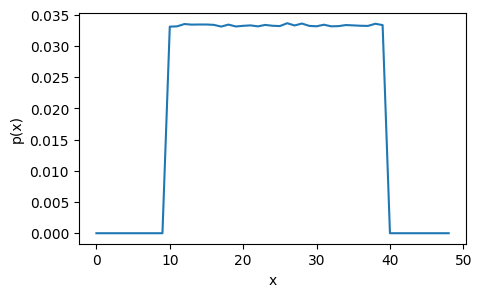

In [5]:
# step 1: create a random number generator object
rng = np.random.default_rng()

# step 2 and 3: call the appropraite method of the generator and store result
samples = rng.uniform(low=10, high=40, size=1_000_000)

# illustrate with plot.
fig, ax = distribution_plot(samples, bins=50)

### 4.2 Exponential distribution

(<Figure size 500x300 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='p(x)'>)

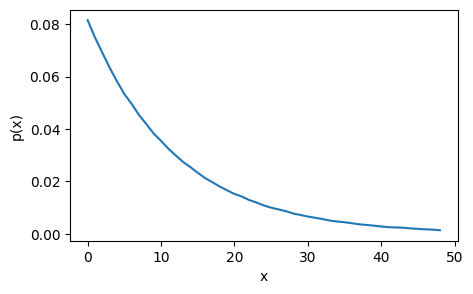

In [6]:
rng = np.random.default_rng()
samples = rng.exponential(scale=12, size=1_000_000)
distribution_plot(samples, bins=50)

## 4.3 Normal distribution

(<Figure size 500x300 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='p(x)'>)

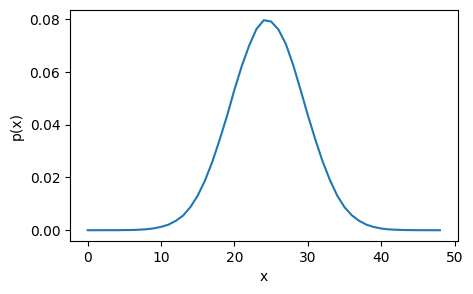

In [7]:
rng = np.random.default_rng()
samples = rng.normal(loc=25.0, scale=5.0, size=1_000_000)
distribution_plot(samples, bins=50)

## 4.4 Generating a single sample

If we just need to generate the a single sample we omit the `size` parameter. This returns a scalar value.

In [8]:
rng = np.random.default_rng()
sample = rng.normal(loc=25.0, scale=5.0)
print(sample)
print(type(sample))

20.42769553691828
<class 'float'>


Note that you can also set `size` to 1.  Just be aware that an array is returned. e.g.

In [9]:
rng = np.random.default_rng()
sample = rng.normal(loc=25.0, scale=5.0, size=1)
# a numpy array is returned
print(sample)
print(type(sample))

# to access the scalar value use the 0 index of the array.
print(sample[0])

[28.05141634]
<class 'numpy.ndarray'>
28.051416342804014


## 5. Controlling sampling in simulations

A Professor of Computer Simulation once told me '*remember that a stochastic simulation is not a random game against nature - you are in control*'.  This has always stuck with me.  What the famous Prof was referring to is that in a simulation we can control the streams of psuedo random numbers and hence make our results repeatable. 

> In case you are wondering **stochastic** here refers to a model that is probabilistic.  This means that a single run of a model does not provide an accurate picture of model performance/behaviour.  You need to run the model multiple times to generate a distribution.

The best way to explain the idea of streams and repeatability is by demonstrating with a simple model. Let's take another look at `numpy.random.Generator`.

Consider a project where you are modelling the length of stay of a patient in a hospital.

* In this pathway/process patients undergo a procedure that requires on average a 3 day spell in hospital. 

Let's test out a simple model where we sample patients length of stay.  We will model the length of stay variable using the exponential distribution.

The first problem will encounter is repeatability.

In [10]:
N_PATIENTS = 5
MEAN_LOS = 3.0

# create a random generator object
rng = np.random.default_rng()

# scale parameter = mean
sample_acute = rng.exponential(scale=MEAN_LOS, size=N_PATIENTS)

# display patient details (in days)
sample_acute

array([9.98023961, 0.67665688, 6.25447518, 0.54665069, 4.13028681])

### 5.1 Problem: repeatability

The first problem we encounter is repeatability. Each time you run the code above you will get a different result.  For any scientific study we produce or publish we want the results to be repeatable.  On a practical level the lack of repeatability makes debugging, testing and fixing code very difficult. We can solve this problem using a random seed.  This is just a parameter you pass to `default_rng`.  Try running the code below multiple times you should get the same results each run.

In [11]:
N_PATIENTS = 5
MEAN_LOS = 3.0
SEED = 42

# create random generator objects and set the SEED.
rng = np.random.default_rng(SEED)

# scale parameter = mean
sample_acute = rng.exponential(scale=MEAN_LOS, size=N_PATIENTS)

# display patient details (in days)
sample_acute

array([7.21262581, 7.00856897, 7.154283  , 0.83938287, 0.2593122 ])

## 6. Encapsulating distributions, parameters, and random seeds.

When building a simulation model it is often useful to *package up* both a random number generator, parameters for a specific distribution, and a seed in a python class.  This allows easy creation of generator objects, straightforward sampling, and improves management of streams for each activity in a simulation model.

As an example here a class `Exponential` representing the exponential distribution. It accepts a mean value parameter and you can set the random seed.

We will then instantiate two `Exponential` objects for two different processes in our simulation: acute length of stay, and rehab length of stay.

In [12]:
class Exponential:
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor

        Params:
        ------
        mean: float
            The mean of the exponential distribution

        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean

    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution

        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)

In [13]:
acute_los = Exponential(3.0, random_seed=42)
rehab_los = Exponential(30.0, random_seed=101)

In [14]:
acute_los.sample()

7.2126258118979845

In [15]:
rehab_los.sample()

122.69065518352762

## 7. Next steps

We can now move onto creating simple `simpy` models that make use of `numpy` sampling.